In [57]:
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score, precision_score, recall_score
import os
from tqdm import tqdm_notebook
from time import ctime
import pickle

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models

In [151]:
# setting directories
ROOT_DIR = os.path.abspath('data/')
TRAIN_JPEG_DIR = os.path.join(ROOT_DIR, 'train-jpg')
TEST_JPEG_DIR = os.path.join(ROOT_DIR, 'test-jpg')
TEST_JPEG_ADD_DIR = os.path.join(ROOT_DIR, 'test-jpg-additional')
TRAIN_TIF_DIR = os.path.join(ROOT_DIR, 'train-tif-v2')
TEST_TIF_DIR = os.path.join(ROOT_DIR, 'test-tif-v3')

In [152]:
with open(os.path.join(ROOT_DIR, 'partition.p'), 'rb') as f:
    partition = pickle.load(f)

In [6]:
with open(os.path.join(ROOT_DIR, 'labels.p'), 'rb') as f:
    labels = pickle.load(f)

In [27]:
with open(os.path.join(ROOT_DIR, 'mlb.p'), 'rb') as f:
    mlb = pickle.load(f)

In [34]:
mlb.classes_

array(['agriculture', 'artisinal_mine', 'bare_ground', 'blooming',
       'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation',
       'habitation', 'haze', 'partly_cloudy', 'primary', 'road',
       'selective_logging', 'slash_burn', 'water'], dtype=object)

In [115]:
def read_image(path):
    im = cv2.imread(path)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [35]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0]) / imagenet_stats[1]

In [25]:
def crop(im, r, c, target_r, target_c):
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """Returns a random crop"""
    r, c, *_ = x.shape
    r, c, *_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c, *_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r, c, *_ = im.shape
    M = cv2.getRotationMatrix2D((c/2, r/2), deg, 1)
    return cv2.warpAffine(im, M, (c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [259]:
class PlanetDataset(Dataset):
    def __init__(self, folder_path, list_IDs, transforms=False, labels=None):
        self.list_IDs = list_IDs
        self.labels = labels
        self.folder_path = folder_path
        self.transforms = transforms
    
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, idx):
        name = self.list_IDs[idx]
        file_path = os.path.join(self.folder_path, name + '.jpg')
        x = cv2.imread(file_path).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
        if self.transforms:
            rdeg = (np.random.random() - 0.50) * 20
            x = rotate_cv(x, rdeg)
            x = random_crop(x)
            if np.random.random() > 0.5:
                x = np.fliplr(x).copy()
        else:
            x = center_crop(x)
        x = normalize(x)
        if self.labels is not None:
            y = self.labels[name]
            return np.rollaxis(x, 2), y
        return np.rollaxis(x, 2)

In [156]:
train_ds = PlanetDataset(TRAIN_JPEG_DIR, partition['inner_train'], labels, True)
val_ds = PlanetDataset(TRAIN_JPEG_DIR, partition['validation'], labels)
test_ds = PlanetDataset(TEST_JPEG_DIR, partition['test'])
test_add_ds = PlanetDataset(TEST_JPEG_ADD_DIR, partition['test_add'])

In [157]:
batch_size = 64
train_dl = DataLoader(train_ds,
                      batch_size=batch_size,
                      num_workers=4,
                      pin_memory=True,
                      shuffle=True)
val_dl = DataLoader(val_ds,
                    batch_size=batch_size,
                    num_workers=4,
                    pin_memory=True)
test_dl = DataLoader(test_ds,
                    batch_size=batch_size,
                    num_workers=4,
                    pin_memory=True)
test_add_dl = DataLoader(test_add_ds,
                         batch_size=batch_size,
                         num_workers=4,
                         pin_memory=True)

In [11]:
class Resnet34(nn.Module):
    def __init__(self, num_classes):
        super(Resnet34, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        # separate conv layers into two groups
        self.groups = nn.ModuleList([nn.Sequential(*h) for h in [layers[:6], layers[6:]]])
        # add a linear layer as the classifier
        self.groups.append(nn.Linear(512, num_classes))
    
    def forward(self, x):
        for group in self.groups[:2]:
            x = group(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = x.view(x.shape[0], -1)
        x = self.groups[2](x)
        return x

    def unfreeze(self,  group_idx:int):
        group = self.groups[group_idx]
        parameters = filter(lambda x: hasattr(x,'requires_grad'), group.parameters())
        for p in parameters: 
            p.requires_grad = True

In [72]:
def validate(model, val_dl, threshold):
    model.eval()
    total_loss = 0
    sum_f2 = 0
    true_labels = []
    predictions = []
    with torch.no_grad():
        for data, target in tqdm_notebook(val_dl, desc='Validation metrics', total=len(val_dl)):
            true_labels.append(target.cpu().numpy())
            data, target = data.cuda().float(), target.cuda().float()
            
            pred = model(data)
            predictions.append(F.sigmoid(pred).cpu().numpy())
            total_loss += F.binary_cross_entropy_with_logits(pred, target).item()
            
        avg_loss = total_loss / len(val_dl)
        predictions = np.vstack(predictions)
        true_labels = np.vstack(true_labels)
        f2_score = fbeta_score(true_labels, predictions > threshold, beta=2, average='samples')
        precision = precision_score(true_labels, predictions > threshold, average='samples')
        recall = recall_score(true_labels, predictions > threshold, average='samples')
        return precision, recall, f2_score, avg_loss

In [89]:
fbeta_score(true_labels, predictions > 0.5, beta=2, average=None)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.83217413, 0.625     , 0.10107817, 0.01754386, 0.        ,
       0.9735263 , 0.79700272, 0.2       , 0.45136375, 0.67571388,
       0.64803805, 0.92745763, 0.98942095, 0.82109809, 0.10714286,
       0.        , 0.69299011])

In [ ]:
f2_score = fbeta_score(true_labels, predictions > threshold, beta=2, average='samples')
precision = precision_score(true_labels, predictions > threshold, average='samples')
recall = recall_score(true_labels, predictions > threshold, average='samples')

In [9]:
def load_model(m, p): m.load_state_dict(torch.load(p))

In [177]:
model = Resnet34(num_classes=17).cuda()
model_path = os.path.join('models', 'model_resnet34_89.pth')
load_model(model, model_path)

In [179]:
validate(model, val_dl, 0.2)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(0.849186351088525,
 0.9477293313570488,
 0.9158972832061628,
 0.09671134261165078)

In [56]:
validate(model, val_dl, 0.2)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(0.9158972832061628, 0.09671134261165078)

In [73]:
threshold_precisions, threshold_recalls = [], []
threshold_f2s = []
ts = np.array(range(1, 100, 5))*0.01
for t in tqdm_notebook(ts, total=len(ts)):
    precision, recall, f2_score, avg_loss = validate(model, val_dl, t)
    threshold_precisions.append(precision)
    threshold_recalls.append(recall)
    threshold_f2s.append(f2_score)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [ ]:
import matplotlib.pyplot as plt

f = plt.figure()
plt.plot(range(10), range(10), "o")
plt.show()

f.savefig("foo.pdf", bbox_inches='tight')

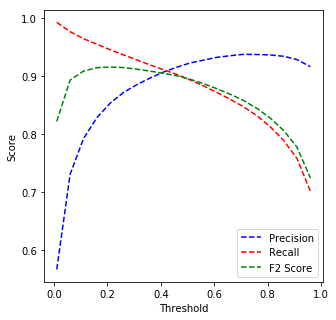

In [174]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(ts, threshold_precisions, 'b--', label='Precision')
ax.plot(ts, threshold_recalls, 'r--', label='Recall')
ax.plot(ts, threshold_f2s, 'g--', label='F2 Score')
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.legend()
plt.savefig('thresholds.pdf')
plt.show()

In [ ]:
def validate(model, val_dl, threshold):
    model.eval()
    total_loss = 0
    sum_f2 = 0
    true_labels = []
    predictions = []
    with torch.no_grad():
        for data, target in tqdm_notebook(val_dl, desc='Validation metrics', total=len(val_dl)):
            true_labels.append(target.cpu().numpy())
            data, target = data.cuda().float(), target.cuda().float()
            
            pred = model(data)
            predictions.append(F.sigmoid(pred).cpu().numpy())
            total_loss += F.binary_cross_entropy_with_logits(pred, target).item()
            
        avg_loss = total_loss / len(val_dl)
        predictions = np.vstack(predictions)
        true_labels = np.vstack(true_labels)
        f2_score = fbeta_score(true_labels, predictions > threshold, beta=2, average='samples')
        precision = precision_score(true_labels, predictions > threshold, average='samples')
        recall = recall_score(true_labels, predictions > threshold, average='samples')
        return precision, recall, f2_score, avg_loss

In [91]:
def make_predictions(model, test_dl):
    predictions = []
    with torch.no_grad():
        for data in tqdm_notebook(test_dl, desc='Test predictions', total=len(test_dl)):
            data = data.cuda().float()
            pred = model(data)
            predictions.append(F.sigmoid(pred).cpu().numpy())
    predictions = np.vstack(predictions)
    return predictions

In [95]:
test_scores = make_predictions(model, test_dl)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [158]:
test_scores_add = make_predictions(model, test_add_dl)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [96]:
partition['test']

['test_18340',
 'test_22676',
 'test_22296',
 'test_25678',
 'test_38',
 'test_22956',
 'test_38321',
 'test_14582',
 'test_25891',
 'test_14769',
 'test_7361',
 'test_17710',
 'test_19521',
 'test_40369',
 'test_8008',
 'test_28115',
 'test_2287',
 'test_21660',
 'test_30298',
 'test_11282',
 'test_28022',
 'test_899',
 'test_18552',
 'test_27418',
 'test_32105',
 'test_11652',
 'test_6088',
 'test_24428',
 'test_15953',
 'test_15682',
 'test_20402',
 'test_8084',
 'test_17347',
 'test_15836',
 'test_6177',
 'test_16029',
 'test_32019',
 'test_22344',
 'test_34426',
 'test_31843',
 'test_9258',
 'test_27800',
 'test_22161',
 'test_22612',
 'test_10193',
 'test_32876',
 'test_22865',
 'test_20011',
 'test_19411',
 'test_9129',
 'test_26749',
 'test_31440',
 'test_40084',
 'test_20646',
 'test_32961',
 'test_33589',
 'test_496',
 'test_26014',
 'test_22189',
 'test_34058',
 'test_9785',
 'test_6717',
 'test_38483',
 'test_7909',
 'test_24836',
 'test_32689',
 'test_26170',
 'test_34947'

In [159]:
threshold = 0.2
predictions = test_scores > threshold
predictions_add = test_scores_add > threshold
tags = mlb.inverse_transform(predictions)
tags_add = mlb.inverse_transform(predictions_add)

In [161]:
test_result_df = pd.DataFrame({'image_name': partition['test'], 'tags': [' '.join(t) for t in tags]})
test_add_result_df = pd.DataFrame({'image_name': partition['test_add'], 'tags': [' '.join(t) for t in tags_add]})
test_result_df = pd.concat([test_result_df, test_add_result_df])

In [164]:
test_result_df.shape

(61191, 2)

blooming clear primary
agriculture partly_cloudy primary
agriculture partly_cloudy primary water
agriculture clear cultivation primary
clear primary
partly_cloudy primary
agriculture clear cultivation primary road
clear primary water
agriculture clear cultivation primary road water
agriculture partly_cloudy primary water


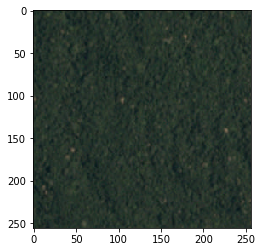

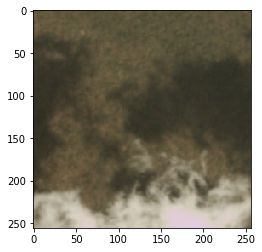

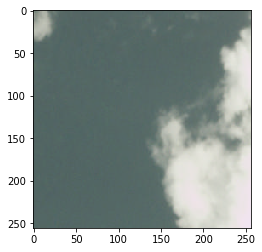

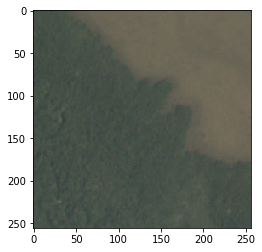

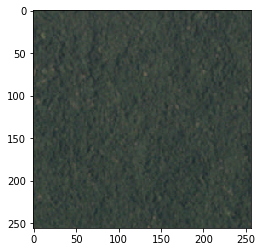

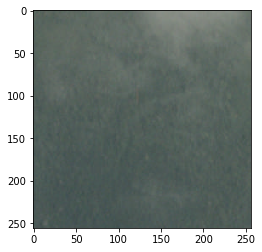

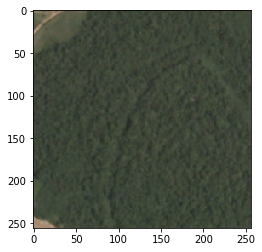

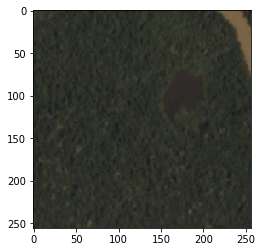

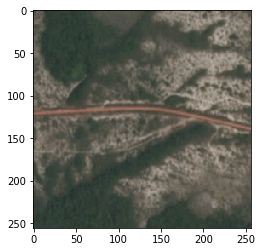

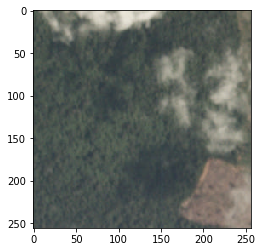

In [123]:
i = 0
for row in test_result_df.itertuples():
    if i == 10: break
    print(row.tag)
    im = read_image(os.path.join(TEST_JPEG_DIR, row.image_name + '.jpg'))
    plt.figure()
    plt.imshow(im)
    i+=1

In [145]:
test_result_df.shape

(40669, 2)

In [148]:
test_file_names = list(os.listdir(TEST_JPEG_DIR))

In [149]:
len(test_file_names)

40669

In [165]:
submission_df = pd.read_csv(os.path.join(ROOT_DIR, 'sample_submission_v2.csv'))
submission_df.drop('tags', axis=1, inplace=True)
submission_df = submission_df.merge(test_result_df, on='image_name')

In [167]:
submission_df.to_csv('out.csv', index=False)

In [166]:
submission_df.shape

(61191, 2)

In [168]:
!head out.csv

image_name,tags
test_0,clear primary
test_1,clear primary
test_2,partly_cloudy primary
test_3,clear primary
test_4,partly_cloudy primary
test_5,clear primary
test_6,agriculture clear cultivation habitation primary road
test_7,clear habitation primary road
test_8,clear primary


In [169]:
!kaggle competitions submit -c planet-understanding-the-amazon-from-space -f out.csv -m "First Submission"

100%|███████████████████████████████████████| 2.26M/2.26M [00:02<00:00, 836kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

## Testing time augmentation

In [ ]:
def val_arrays(model, dl):
    model.eval()
    preds = []
    ys = []
    for x, y in dl:
        x = x.cuda().float()
        out = model(x)
        pred = (out > 0.0).long()
        preds.append(pred.cpu().numpy())
        ys.append(y.unsqueeze(1).numpy())
    return np.vstack(preds), np.vstack(ys)

In [ ]:
def TTAaccuracy(model, valid_dl, valid_dl_trs, ndls=4):
    preds, ys = val_arrays(model, valid_dl)
    pred_tuples = [val_arrays(model, valid_dl_trs) for i in range(ndls)]
    tr_preds = [p for p,y in pred_tuples]
    pp = np.hstack(tr_preds + [preds])
    final_prob = pp.mean(1)
    final_prediction = final_prob > 0.5
    return (final_prediction[:, None] == ys).sum()/len(final_prediction)

In [181]:
def make_val_predictions(model, val_dl):
    true_labels, predictions = [], []
    model.eval()
    with torch.no_grad():
        for data, target in tqdm_notebook(val_dl, desc='Validation metrics', total=len(val_dl)):
            true_labels.append(target.cpu().numpy())
            data, target = data.cuda().float(), target.cuda().float()
            pred = model(data)
            predictions.append(F.sigmoid(pred).cpu().numpy())
        return np.vstack(predictions), np.vstack(true_labels)

In [272]:
def make_test_predictions(model, test_dl):
    predictions = []
    model.eval()
    with torch.no_grad():
        for data in tqdm_notebook(test_dl, desc='Test prediction', total=len(test_dl)):
            data = data.cuda().float()
            pred = model(data)
            predictions.append(F.sigmoid(pred).cpu().numpy())
        return np.vstack(predictions)

In [186]:
val_ds_aug = PlanetDataset(TRAIN_JPEG_DIR, partition['validation'], labels, True)
val_dl_aug = DataLoader(val_ds_aug,
                        batch_size=batch_size,
                        num_workers=4,
                        pin_memory=True)

In [197]:
predictions, true_labels = make_predictions(model, val_dl)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [190]:
tta_results = [make_predictions(model, val_dl_aug) for _ in range(4)]

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [191]:
tta_predictions = [prediction for prediction, true_labels in tta_results]

In [211]:
tta_predictions[0].shape

(8096, 17)

In [212]:
len(tta_predictions)

4

In [213]:
tta_predictions = tta_predictions + [predictions]

In [224]:
tta_predictions_combined = np.mean(tta_predictions, axis=0)

In [227]:
tta_predictions_combined

(8096, 17)

In [230]:
tta_predictions_combined > 0.2

array([[ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False,  True],
       [ True, False, False, ..., False, False,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True]])

In [237]:
fbeta_score(true_labels, tta_predictions_combined > 0.2, beta=2, average='samples')

0.9180990246379899

In [245]:
ts = np.linspace(0, 1, 100)
f2_scores = [fbeta_score(true_labels, tta_predictions_combined > t, beta=2, average='samples') for t in ts]
precision_scores = [precision_score(true_labels, tta_predictions_combined > t, average='samples') for t in ts]
recall_scores = [recall_score(true_labels, tta_predictions_combined > t, average='samples') for t in ts]

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


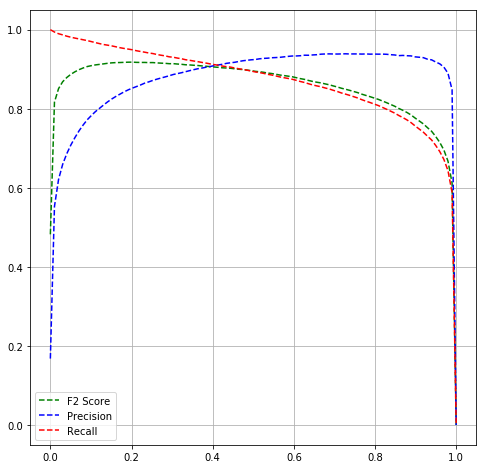

In [248]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ts, f2_scores, 'g--', label='F2 Score')
ax.plot(ts, precision_scores, 'b--', label='Precision')
ax.plot(ts, recall_scores, 'r--', label='Recall')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def validate(model, val_dl, threshold):
    model.eval()
    total_loss = 0
    sum_f2 = 0
    true_labels = []
    predictions = []
    with torch.no_grad():
        for data, target in tqdm_notebook(val_dl, desc='Validation metrics', total=len(val_dl)):
            true_labels.append(target.cpu().numpy())
            data, target = data.cuda().float(), target.cuda().float()
            
            pred = model(data)
            predictions.append(F.sigmoid(pred).cpu().numpy())
            total_loss += F.binary_cross_entropy_with_logits(pred, target).item()
            
        avg_loss = total_loss / len(val_dl)
        predictions = np.vstack(predictions)
        true_labels = np.vstack(true_labels)
        f2_score = fbeta_score(true_labels, predictions > threshold, beta=2, average='samples')
        precision = precision_score(true_labels, predictions > threshold, average='samples')
        recall = recall_score(true_labels, predictions > threshold, average='samples')
        return precision, recall, f2_score, avg_loss

In [176]:
model

Resnet34(
  (groups): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.

In [260]:
test_ds = PlanetDataset(TEST_JPEG_DIR, partition['test'])
test_add_ds = PlanetDataset(TEST_JPEG_ADD_DIR, partition['test_add'])
test_ds_aug = PlanetDataset(TEST_JPEG_DIR, partition['test'], True)
test_add_ds_aug = PlanetDataset(TEST_JPEG_ADD_DIR, partition['test_add'], True)

test_dl = DataLoader(test_ds,
                     batch_size=batch_size,
                     num_workers=4,
                     pin_memory=True)
test_dl_aug = DataLoader(test_ds_aug,
                         batch_size=batch_size,
                         num_workers=4,
                         pin_memory=True)
test_add_dl = DataLoader(test_add_ds,
                         batch_size=batch_size,
                         num_workers=4,
                         pin_memory=True)
test_add_dl_aug = DataLoader(test_add_ds_aug,
                             batch_size=batch_size,
                             num_workers=4,
                             pin_memory=True)

In [261]:
next(iter(test_add_dl_aug))

tensor([[[[-1.5091, -1.5386, -1.5704,  ..., -1.4690, -1.5199, -1.5502],
          [-1.5068, -1.5383, -1.5688,  ..., -1.4716, -1.5028, -1.4988],
          [-1.5199, -1.5359, -1.5436,  ..., -1.4350, -1.4196, -1.3987],
          ...,
          [-1.6584, -1.7379, -1.6981,  ..., -1.5878, -1.5501, -1.5834],
          [-1.6344, -1.7069, -1.6692,  ..., -1.5986, -1.5686, -1.5885],
          [-1.6264, -1.6577, -1.6255,  ..., -1.6173, -1.6011, -1.6027]],

         [[-1.3318, -1.3130, -1.3125,  ..., -1.2156, -1.2393, -1.3098],
          [-1.3327, -1.3152, -1.3114,  ..., -1.2111, -1.2043, -1.2583],
          [-1.3302, -1.2999, -1.2928,  ..., -1.1939, -1.1659, -1.2036],
          ...,
          [-1.4706, -1.5227, -1.5619,  ..., -1.3855, -1.4120, -1.4128],
          [-1.4492, -1.4979, -1.5152,  ..., -1.3723, -1.3911, -1.4071],
          [-1.4298, -1.4645, -1.4788,  ..., -1.3721, -1.3881, -1.3927]],

         [[-1.3654, -1.3477, -1.3324,  ..., -1.2971, -1.2970, -1.3007],
          [-1.3660, -1.3486, -

In [273]:
def make_tta_prediction(model, test_dl, test_dl_aug, n_tta):
    predictions = make_test_predictions(model, test_dl)
    tta_predictions = []
    for _ in tqdm_notebook(range(n_tta), desc='Testing time augmentation'):
        tta_predictions.append(make_test_predictions(model, test_dl_aug))
    tta_predictions = tta_predictions + [predictions]
    tta_predictions = np.mean(tta_predictions, axis=0)
    return tta_predictions

In [278]:
tta_predictions = make_tta_prediction(model, test_dl, test_dl_aug, 4)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [279]:
tta_add_predictions = make_tta_prediction(model, test_add_dl, test_add_dl_aug, 4)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [280]:
threshold = 0.2
tta_predictions_hard = tta_predictions > threshold
tta_predictions_add_hard = tta_add_predictions > threshold
tags = mlb.inverse_transform(tta_predictions_hard)
tags_add = mlb.inverse_transform(tta_predictions_add_hard)

In [281]:
test_result_df = pd.DataFrame({'image_name': partition['test'], 'tags': [' '.join(t) for t in tags]})
test_add_result_df = pd.DataFrame({'image_name': partition['test_add'], 'tags': [' '.join(t) for t in tags_add]})
test_result_df = pd.concat([test_result_df, test_add_result_df])

In [283]:
submission_df = pd.read_csv(os.path.join(ROOT_DIR, 'sample_submission_v2.csv'))
submission_df.drop('tags', axis=1, inplace=True)
submission_df = submission_df.merge(test_result_df, on='image_name')

In [284]:
submission_df.to_csv('out.csv', index=False)

In [285]:
!head out.csv

image_name,tags
test_0,clear primary
test_1,clear primary
test_2,partly_cloudy primary
test_3,clear primary
test_4,partly_cloudy primary
test_5,clear primary
test_6,agriculture clear cultivation habitation haze primary road
test_7,clear habitation primary road
test_8,clear primary


In [286]:
!kaggle competitions submit -c planet-understanding-the-amazon-from-space -f out.csv -m "TTA Submission"

100%|███████████████████████████████████████| 2.26M/2.26M [00:03<00:00, 752kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space